In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import caffe
import os
import time
import datetime
%matplotlib inline

In [14]:
def myImgShow(img):      #将opencv对象转为plt对象，以显示在jupyter上
    #print("show ",img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)  #RGB
    plt.show()

In [15]:
def drawPic(img0,x,y,w,h,color): #输入img为pil.image,根据x,y,w,h画上识别框
    img = img0.copy()
    #print("draw ",img.shape)
    if color == 'red':
        paintColor = (0,0,250)
    cv2.circle(img,(int(x),int(y)),10, paintColor,-1)
    x1 = x - w/2
    x2 = x + w/2
    y1 = y - h/2
    y2 = y + h/2
    cv2.line(img, (int(x1),int(y1)),(int(x2),int(y1)),paintColor,7)
    cv2.line(img, (int(x2),int(y1)),(int(x2),int(y2)),paintColor,7)
    cv2.line(img, (int(x1),int(y2)),(int(x2),int(y2)),paintColor,7)
    cv2.line(img, (int(x1),int(y1)),(int(x1),int(y2)),paintColor,7)
    myImgShow(img)

In [16]:
#图片初始化，先缩放，然后在进行简单的归一化
def imgPrepare(img):
    img = cv2.resize(img,(448,448))
    #print(img.shape)   #H,W,C
    mean = np.ones((448,448,3))*127.5
    img = (img-mean)*0.00784
    return img

   


In [17]:
#计算IOU
def iouBox(frame1,frame2):   #计算frame1,frame2的iou,frame1,2分别是[4]，(x,y,w,h)
       
    left = frame1[0] if frame1[0]>frame2 [0] else frame2[0]
    right = (frame1[0]+frame1[2]) if (frame1[0]+frame1[2]) < (frame2[0]+frame2[2]) else (frame2[0]+frame2[2])
    up = frame1[1] if frame1[1]>frame2 [1] else frame2[1]
    down = (frame1[1]+frame1[3]) if (frame1[1]+frame1[3]) < (frame2[1]+frame2[3]) else (frame2[1]+frame2[3])
    if (right - left < 0) or (down - up < 0):
        return 0
    allArea = frame1[2] * frame1[3] + frame2[2]*frame2[3] - (right-left)*(down-up)
    return (right-left)*(down-up)/allArea


In [37]:
#对图片应用模型进行检测
def detecPic(imgAdd,net,stand_frame):     #输入图片地址,net,标准frame[4]
    imgori = cv2.imread(imgAdd)  #BGR  (H,W,C)
    #myImgShow(imgori)
    img = imgPrepare(imgori) #图片去均值，“归一化”，即训练的时候图片进行的预处理
    traformed_image = transformer.preprocess('data',img)  #BGR (C,H,W)，相对于其他图片载入方式，opencv只需要将(H,W,C)转换为(C,W,H)
    
    net.blobs['data'].data[...] = traformed_image   #设置网络输入层
    output = net.forward()         #进行预测
    
    w = imgori.shape[1]
    h = imgori.shape[0]
    
    #输出图片根据训练图片时的预处理方式进行转换，并画图
    #找出大于thresh阈值的所有人脸，并找到两个框confidence最大的一个
    #计算其x,y,w,h，其中w,h回归的是其开方
    side = 11
    num = 2
    thresh = 0.5
    out = output['fc12'][0]
    out_frame = []
    for i in range(side*side):
        bestcon = 0
        x0 = 0
        y0 = 0
        w0 = 0
        h0 = 0
        flag_detect = 0
        for inum in range(2):
            confidence_index = side*side + num * i + inum
            prop = out[confidence_index] * out[i] #概率=置信度×类别信息
            if out[confidence_index] < bestcon:
                continue
            bestcon = out[confidence_index]   #找到两个网格confidence较大的一个
            if prop > thresh:
                flag_detect = 1 # 标注已经检测到人脸
                x_index = (1+num)*side*side + num*4*i + 4*inum
                y_index = x_index+1
                w_index = x_index+2
                h_index = x_index+3
                x0 = out[x_index]*w
                y0 = out[y_index]*h
                w0 = out[w_index]*out[w_index]*w
                h0 = out[h_index]*out[h_index]*h
                #print("here ",x0,y0,w0,h0,flag_detect)
        if flag_detect > 0:
            #print("here ",x0,y0,w0,h0,flag_detect)
            out_frame.append((x0,y0,w0,h0))
    for i in range(len(out_frame)):
        x0 = out_frame[i][0]
        y0 = out_frame[i][1]
        w0 = out_frame[i][2]
        h0 = out_frame[i][3]
        drawPic(imgori,x0,y0,w0,h0,'red')
    
    tempout = (x0-w0/2,y0-h0/2,w0,h0)
    for i in range(len(stand_frame)):
        stand_frame[i] = int(stand_frame[i])
    iouout = iouBox(tempout,stand_frame)
    return iouout

In [26]:
caffe_root = '/home/lgh/caffe'
yolo_root = '/home/lgh/code/yolo/'
caffe.set_mode_gpu()

model_def =  yolo_root + "yolo-face-deploy.prototxt"
model_weights = yolo_root + "noside/_iter_25000.caffemodel"
net = caffe.Net(model_def, model_weights,caffe.TEST)

In [27]:
net.blobs['data'].data.shape

(1, 3, 448, 448)

In [28]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))    #将(H,W,C)转换为(C,W,H)
#transformer.set_raw_scale('data', 255)        #将0-1空间转换为0-255空间
#transformer.set_channel_swap('data', (2,1,0))  #将RGB转为caffe用的BGR通道


In [29]:
net.blobs['data'].reshape(13,3,448,448)

In [35]:
#对1000张图片进行测试
pic_root = '/media/lgh/Passport/sharefolder/CelebA/Img/img_celeba.7z/img_celeba/'
standf = open(yolo_root + "testbbox.txt",mode='r')
start = datetime.datetime.now()
aveIOU = 0
numIOU = 0
for iPic in range(1000):
    templine = standf.readline().split()
    tempIOU = detecPic(pic_root+templine[0],net,templine[1:])
    aveIOU += tempIOU
    if tempIOU == 0:
        numIOU += 1
    print(iPic)
end = datetime.datetime.now()
aveIOU = aveIOU/1000
print("time ",(end-start).seconds)    #15帧数每秒        97.8%正确率，平均IOU为84.3%

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
print(aveIOU)
print(numIOU)

0.843372770195
23


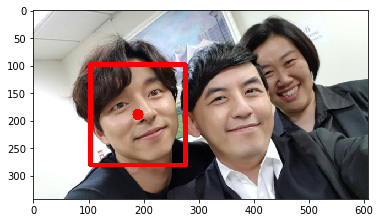

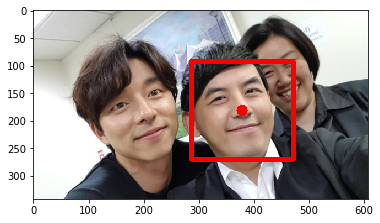

0

In [39]:
detecPic("2.jpg",net,[0,0,0,0])